
### Prerequisite

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
##from lmfit import minimize, Parameters, report_fit, Model
from scipy.interpolate import interp1d
import csv
import sys
import collections
from sets import Set
from scipy.stats import t

----
### Import data

In [2]:
#fl_amp = np.genfromtxt('/Users/dongyang/Dropbox/20151010_6aa_gendup.csv', delimiter = ',')
fl_amp = np.genfromtxt('/Users/dongyang/Dropbox/20151019_MOPS_sorbitol_fl.txt', delimiter = ',')
##fl_full = np.genfromtxt('/Users/dongyang/Documents/MATLAB/fl_amp.csv', delimiter=",")
g_12aa = np.genfromtxt('/Users/dongyang/Documents/MATLAB/g_12aa_coord.csv', delimiter = ',')
##g_few = np.genfromtxt('/Users/dongyang/Documents/MATLAB/g_coord.csv', delimiter = ',')
##tau = np.genfromtxt('/Users/dongyang/Documents/MATLAB/tau.csv', delimiter=',')
##g_all = np.genfromtxt('/Users/dongyang/Documents/MATLAB/g_all_primers.csv', delimiter = ',')
##fl_new = np.genfromtxt('/Users/dongyang/Documents/MATLAB/all_primers_test_fl.csv', delimiter = ',')
## used 12-18 as reference cycles

In [3]:
##fl_1007 = np.genfromtxt('/Users/dongyang/Dropbox/fl_20151007.csv', delimiter = ',')
g_1007 = [0.45, -0.54, -0.02, 0.02, -0.98, 0.98, 0, 1]
## used 17-23 as reference cycles.
tau = np.genfromtxt('/Users/dongyang/Dropbox/20151019_MOPS_sorbitol_tau.txt', delimiter = ',')
##tau

----
### Subtract background

In [4]:
##fl_amp = fl_full
fl_amp_n = np.zeros(fl_amp.shape)
for i in range(fl_amp.shape[1]):
    bck_fitmdl = np.polyfit(range(1,11,1), fl_amp[0:10,i],1)
    f = np.poly1d(bck_fitmdl)
    fl_amp_n[:,i] = fl_amp[:,i] - f(range(1,41,1))

----
### Ct evaluation

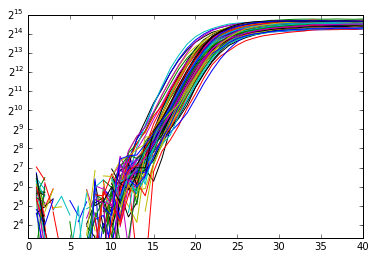

In [5]:
fl_plot = plt.figure()
for i in range(fl_amp.shape[1]):
    plt.semilogy(range(1,41), fl_amp_n[:,i],'-', basey=2)
ymin, ymax = plt.ylim()
plt.ylim((10, ymax))
plt.show()
##plot_url = py.plot_mpl(fl_plot, filename='fl_amp')
##tls.embed(plot_url)

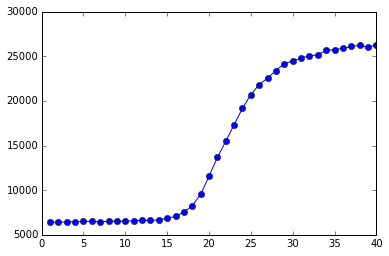

In [6]:
plt.figure()
plt.plot(range(1,41), fl_amp[:,0], '-o')
plt.show()

In [ ]:
temp158_fitmdl = np.polyfit(range(1,21,1), fl_amp[0:20,158],1)
f_158 = np.poly1d(temp158_fitmdl)
fl_amp_n[:,158] = fl_amp[:,158] - f_158(range(1,41,1))
plt.plot(range(1,41), fl_amp_n[:,158], '-o')
plt.show()

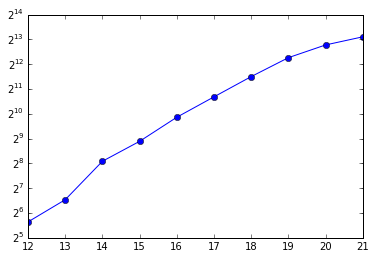

In [9]:
plt.figure()
plt.semilogy(range(12,22), fl_amp_n[12:22,0], '-o', basey = 2)
plt.show()
##ct[158]-ct[0]
##fl_amp_n[19,158] = np.exp(3)
##fl_amp_n[20, 158] = np.exp(4)
##np.log(fl_amp_n[:,158])


In [10]:
mid_fluo_level = 2000
ct = np.zeros(fl_amp.shape[1])
for i in range(fl_amp.shape[1]):
    if fl_amp_n[-1,i] > mid_fluo_level:
        f_interp = interp1d(range(1,41,1), fl_amp_n[:,i], kind='cubic')
        interp_range = np.arange(1,40,0.01)
        y_interp = f_interp(interp_range).flatten()
        ct[i] = interp_range[np.nonzero(y_interp>mid_fluo_level)[0][0]]
    else:
        ct[i] = 40

----
### Fitting amplification efficiency

[ 4.53077313  5.6048881   6.16262557  6.83582303  7.40580878  7.97192669
  8.50072993  8.85641575]


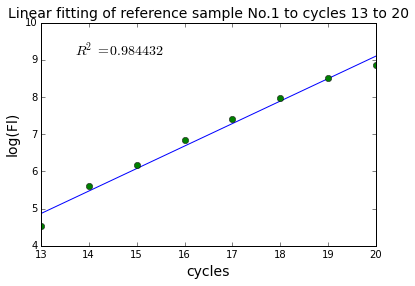

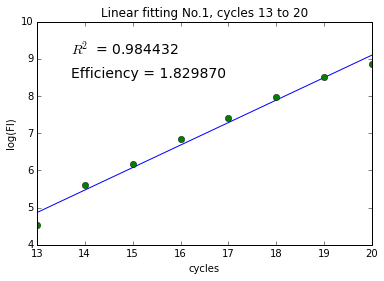

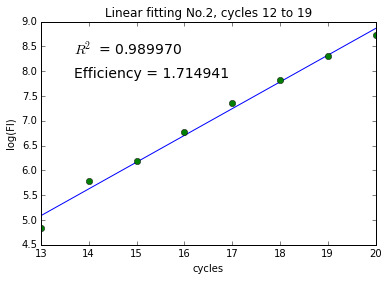

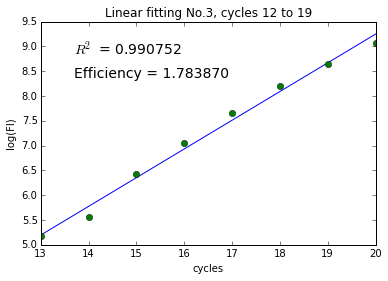

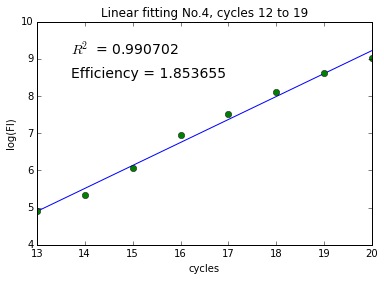

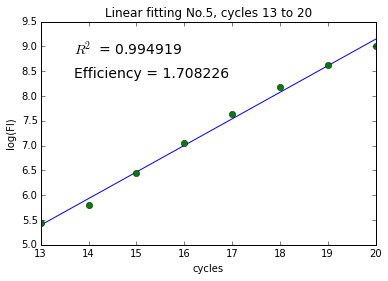

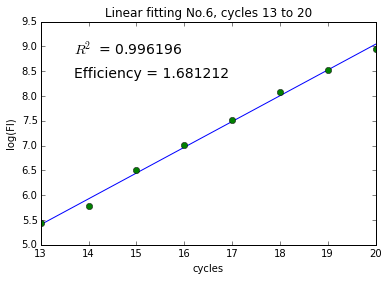

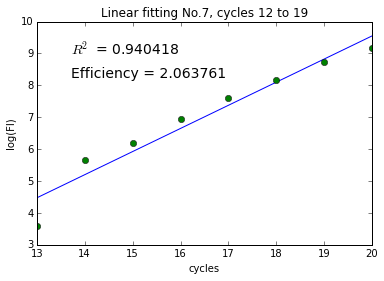

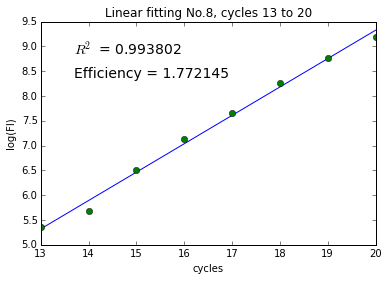

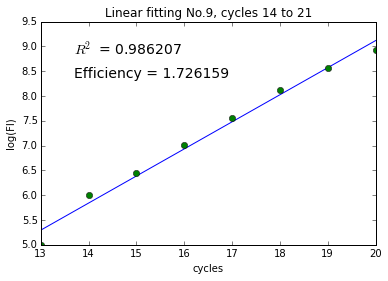

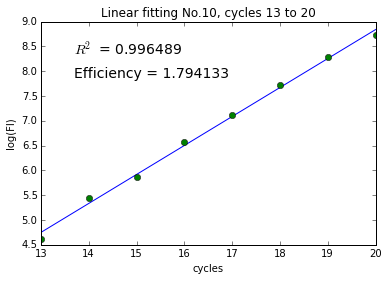

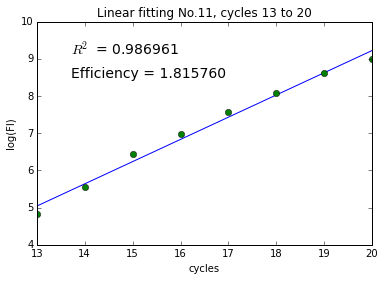

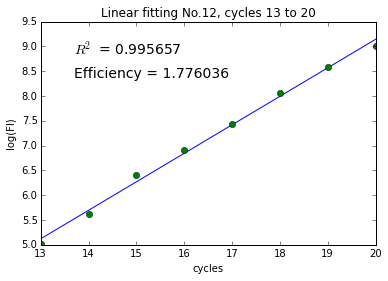

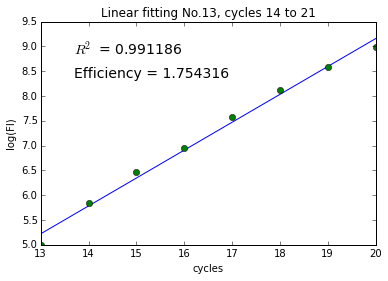

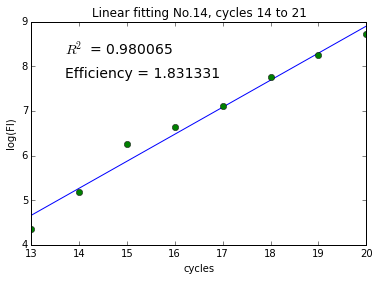

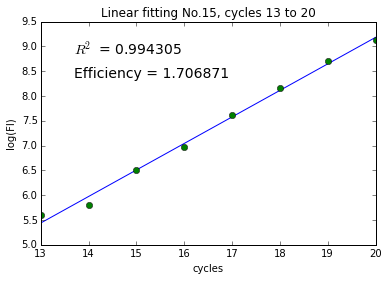

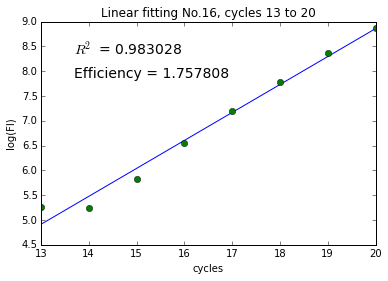

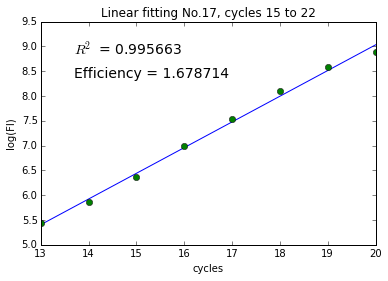

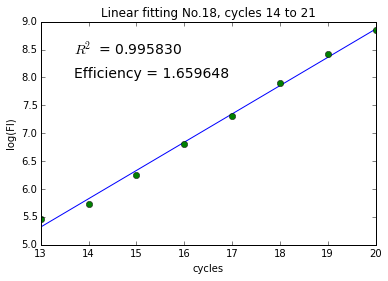

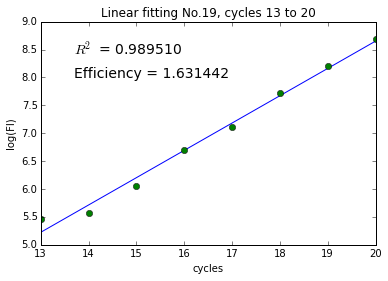

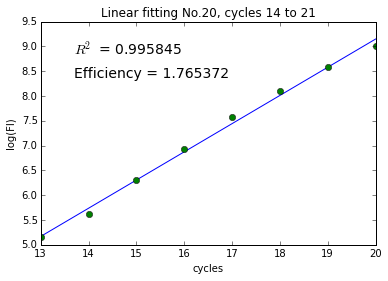

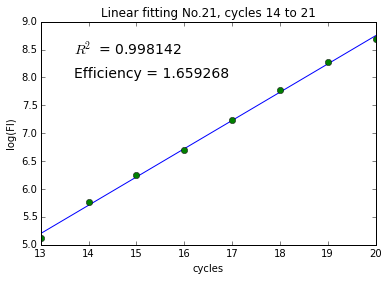

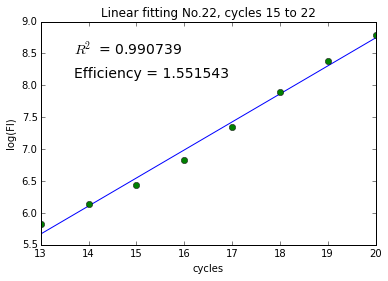

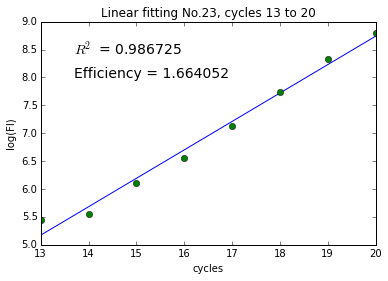

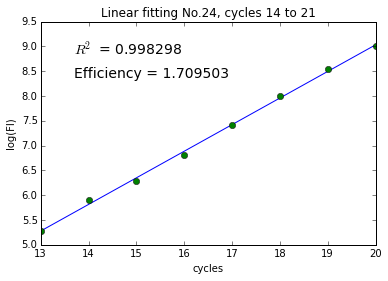

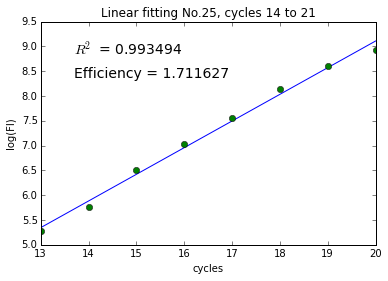

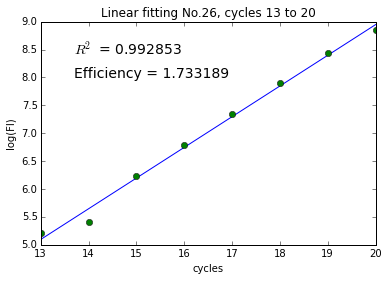

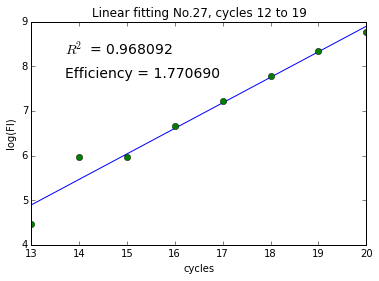

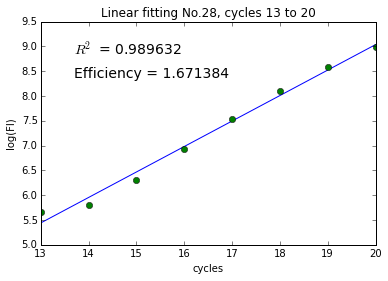

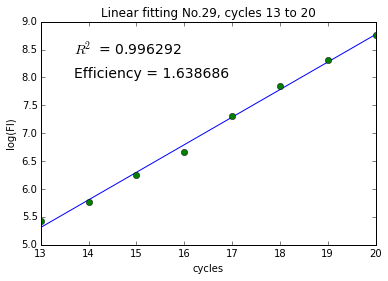

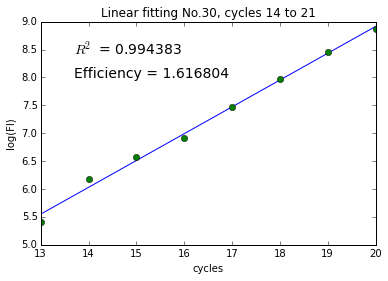

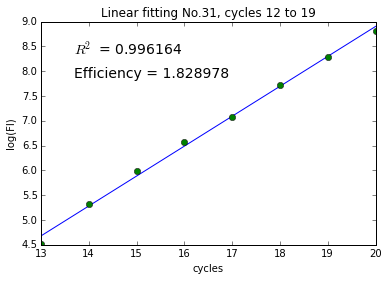

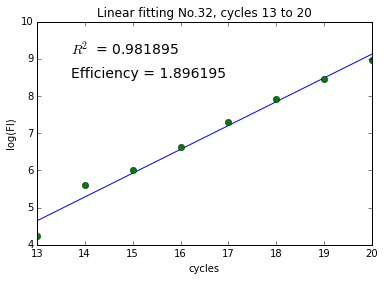

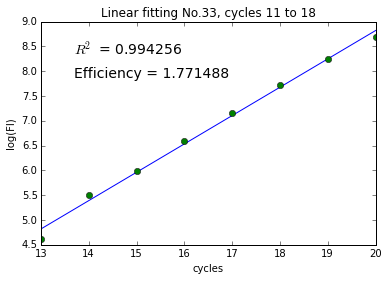

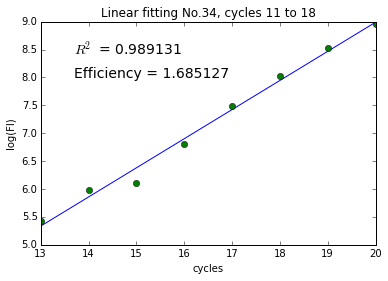

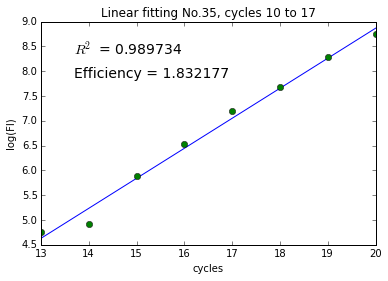

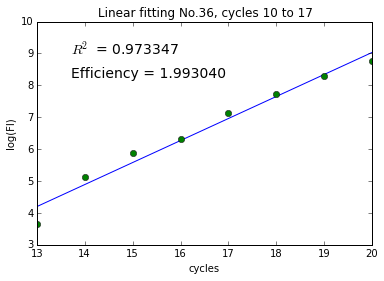

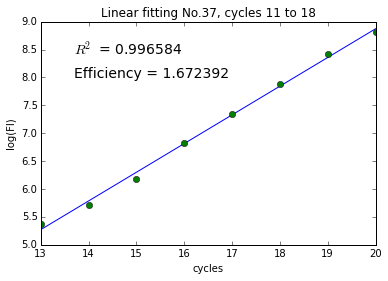

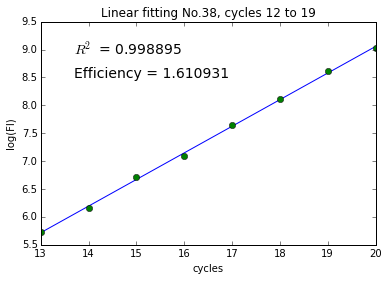

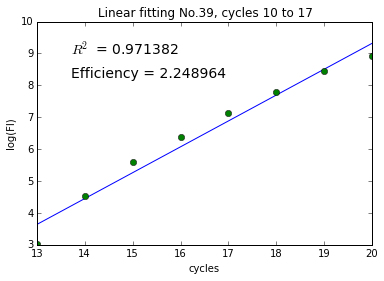

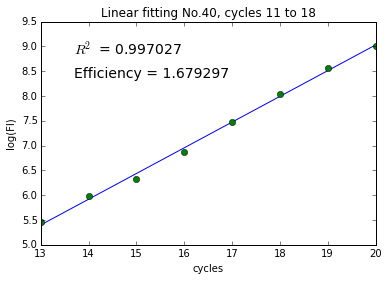

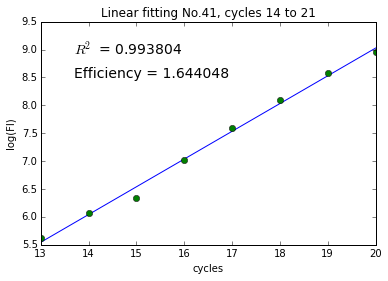

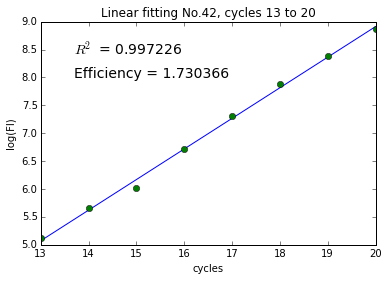

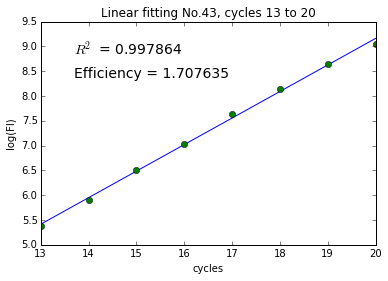

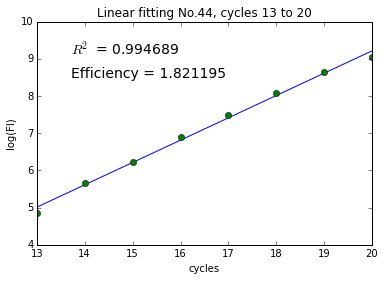

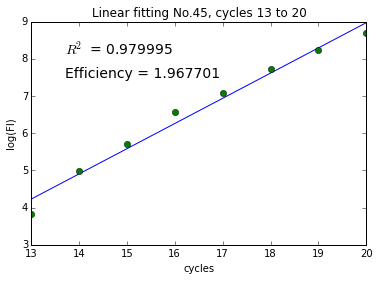

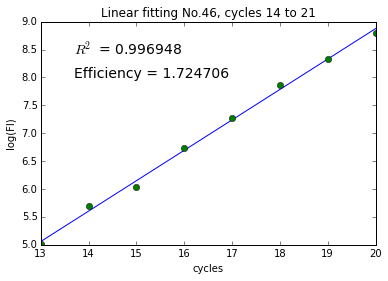

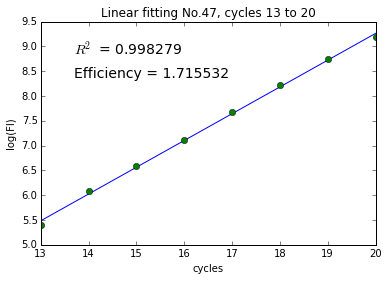

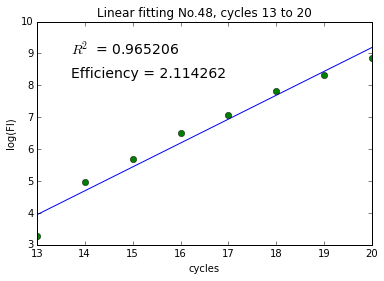

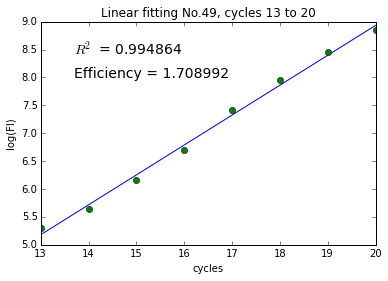

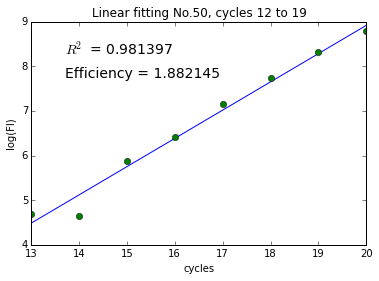

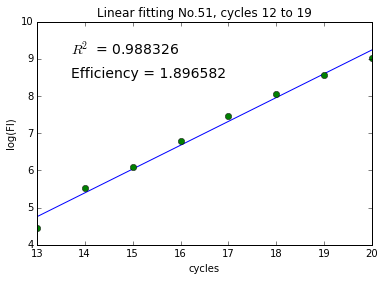

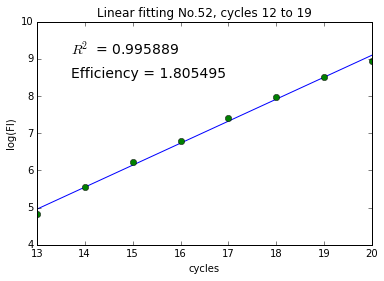

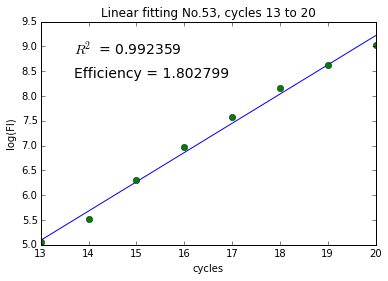

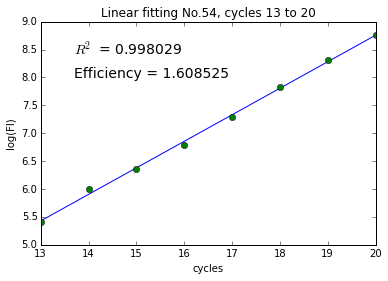

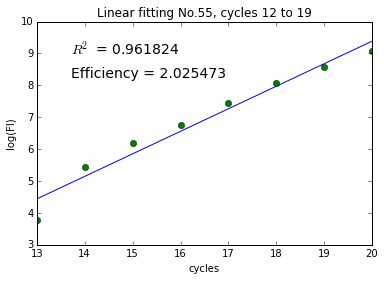

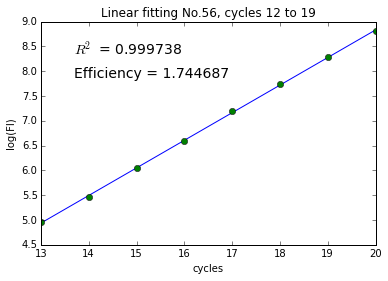

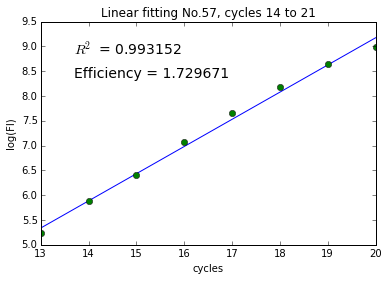

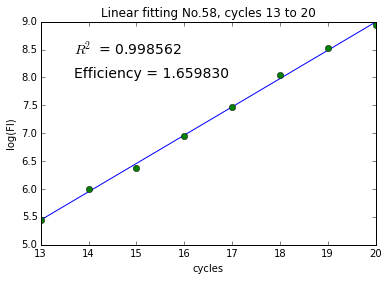

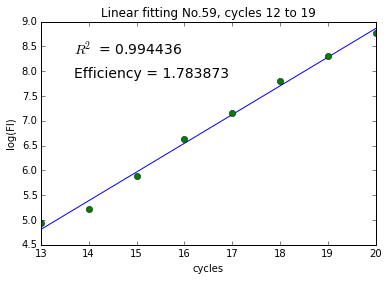

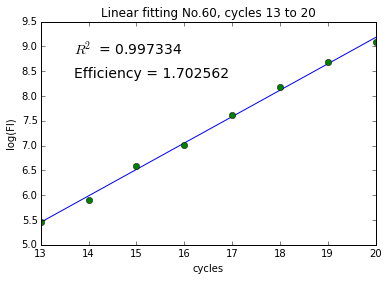

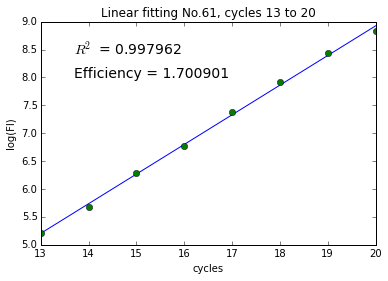

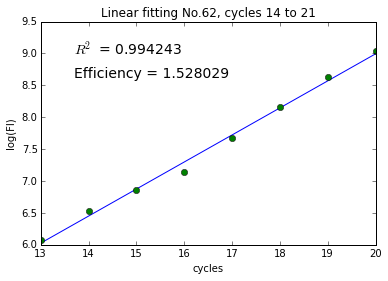

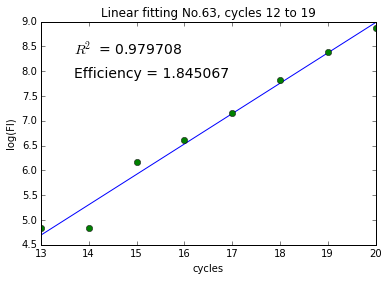

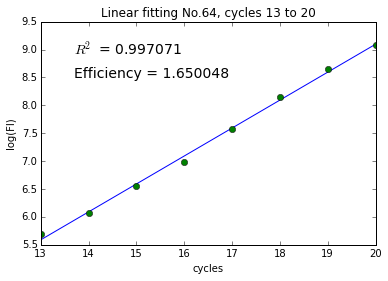

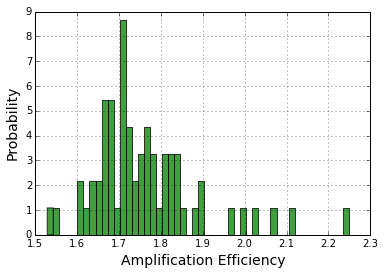

In [16]:
## define range of fitting cycles, has to be manually tiknkered and inspected here!
ref_trace_id = 0
c_low_ref = 13
c_up_ref = 20
fit_range = range(c_low_ref, c_up_ref+1, 1)

## fitting log-transformed data
ydata = np.log(fl_amp_n[c_low_ref:c_up_ref+1,0])
fitFunc = np.polyfit(fit_range, ydata, 1, full=False, w=None, cov=False)
yhat = np.polyval(fitFunc, fit_range)
print(ydata)
## calculating R^2
ss_tot = np.sum((ydata - np.mean(ydata))**2)  
ss_res = np.sum((ydata-yhat)**2)
r_squared = 1 - ss_res/ss_tot

## plotting
plt.figure()
plt.plot(fit_range, yhat, '-', fit_range, ydata, 'o')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.xlabel('cycles', fontsize = 14)
plt.ylabel('log(Fl)', fontsize = 14)
plt.title('Linear fitting of reference sample No.%d to cycles %d to %d' \
          %(ref_trace_id+1, c_low_ref, c_up_ref), fontsize = 14)
plt.text(0.1*(xmax-xmin)+xmin, 0.85*(ymax-ymin)+ymin, r'$R^2 = %f$' % (r_squared), fontsize = 14)
plt.show()

## fit every trace based on the reference trace
show_plot = True
shift_cycle = np.zeros(fl_amp.shape[1])
eff = np.zeros(fl_amp.shape[1])
rsq = np.zeros(fl_amp.shape[1])
c_low = c_low_ref
c_up = c_up_ref
for i in range(fl_amp.shape[1]):
    shift_cycle[i] = ct[i]-ct[ref_trace_id]
    c_low = c_low_ref + np.round(shift_cycle[i])
    c_up = c_low + (c_up_ref - c_low_ref)
    eff[i], rsq[i] = fit_for_eff(c_low, c_up, fl_amp_n[:,i], i, show_plot)
    
## Histogram of amplification efficiency
plt.figure()
n, bins, patches = plt.hist(eff, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Amplification Efficiency', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.grid(True)
plt.show()

In [17]:
np.nanmean(eff)

1.7617301334882942

----
### Pairwise ratio calculation

Grouping of data and assign genome coordinate $g$

processing sample Sorbitol
trace number: 1 to 8


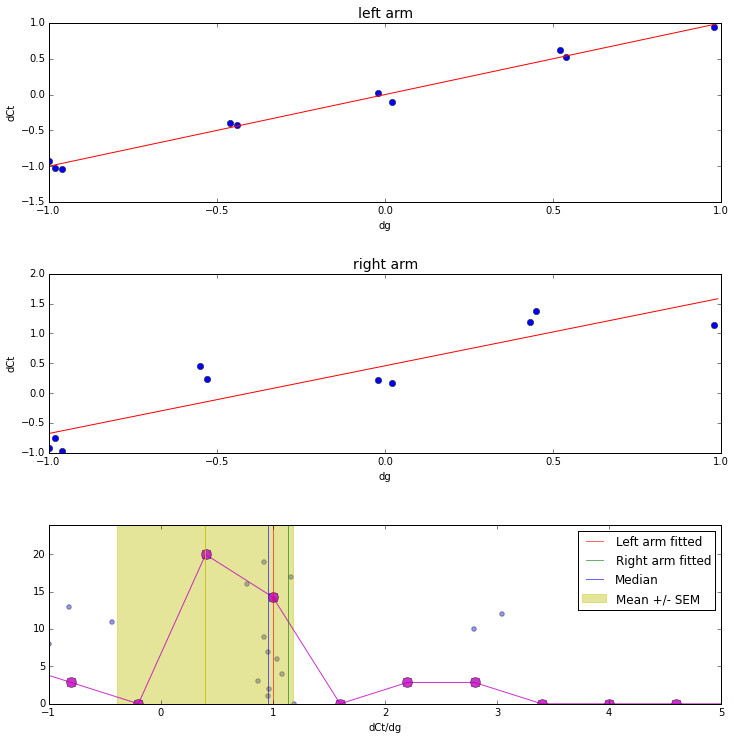

left arm fitted C/tau = 0.999643; right arm fitted C/tau = 1.133481
Median dCt/dg = 0.956865
mean and std and sem = 0.396235, 3.506209, 0.784012
**************************************************
trace number: 9 to 16


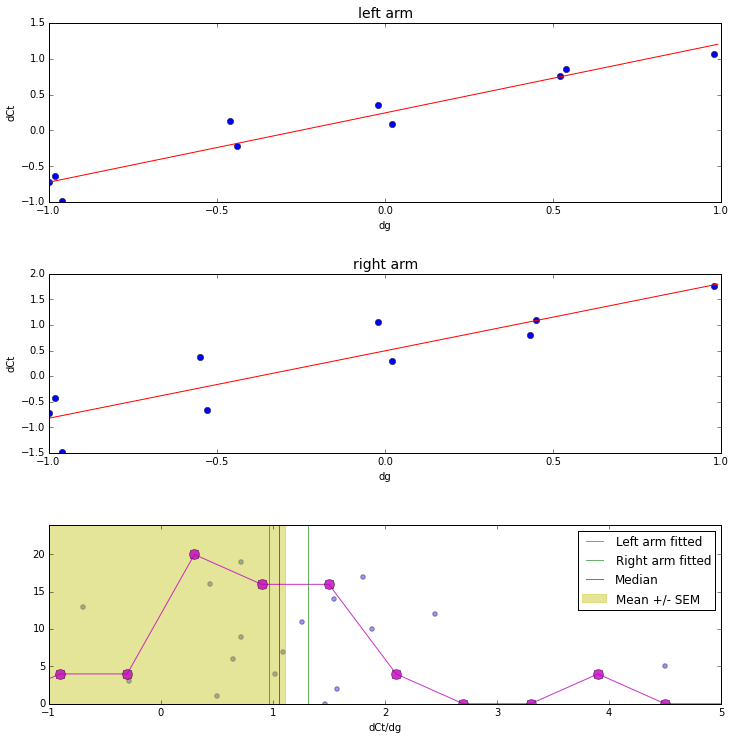

left arm fitted C/tau = 0.967101; right arm fitted C/tau = 1.316775
Median dCt/dg = 1.056335
mean and std and sem = -1.743175, 12.763787, 2.854070
**************************************************
trace number: 17 to 24


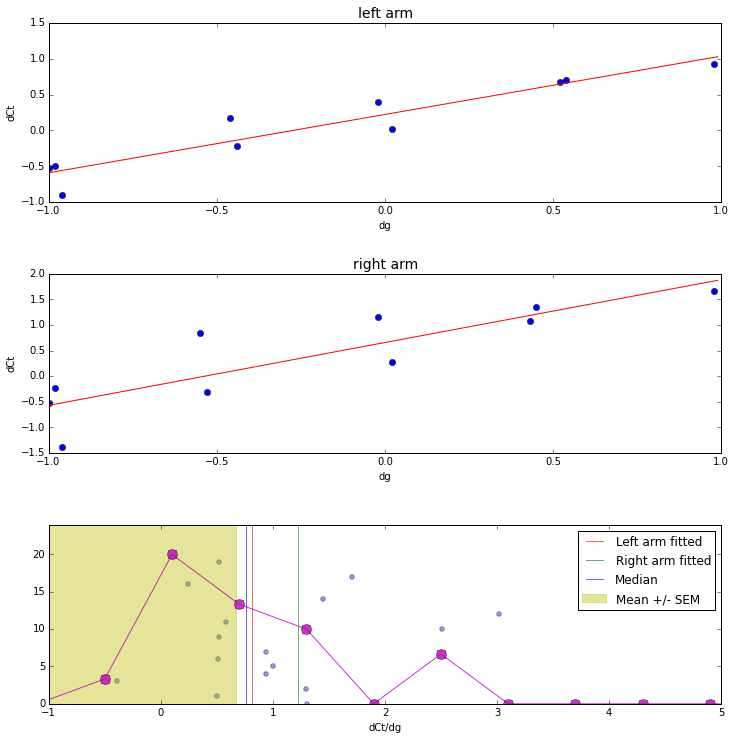

left arm fitted C/tau = 0.813659; right arm fitted C/tau = 1.226980
Median dCt/dg = 0.761203
mean and std and sem = -2.418623, 13.812652, 3.088603
**************************************************
trace number: 25 to 32


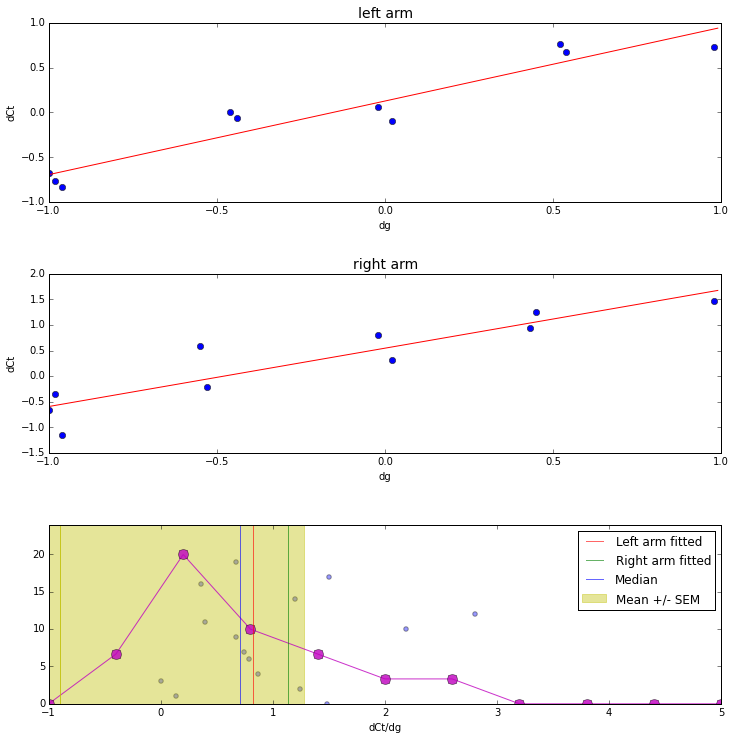

left arm fitted C/tau = 0.821639; right arm fitted C/tau = 1.139521
Median dCt/dg = 0.707449
mean and std and sem = -0.902116, 9.741743, 2.178320
**************************************************
trace number: 33 to 40


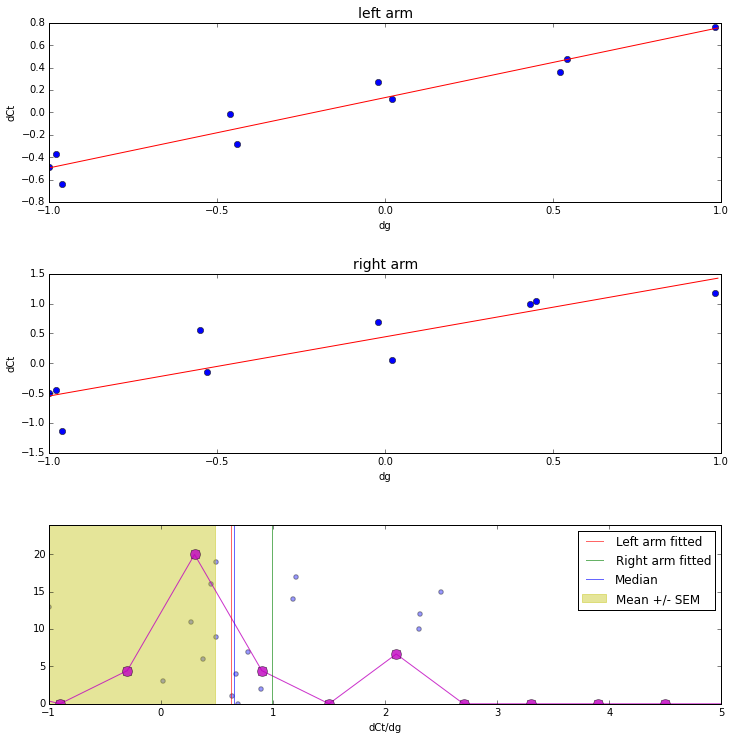

left arm fitted C/tau = 0.628343; right arm fitted C/tau = 0.991802
Median dCt/dg = 0.651515
mean and std and sem = -1.387662, 8.349641, 1.867036
**************************************************
trace number: 41 to 48


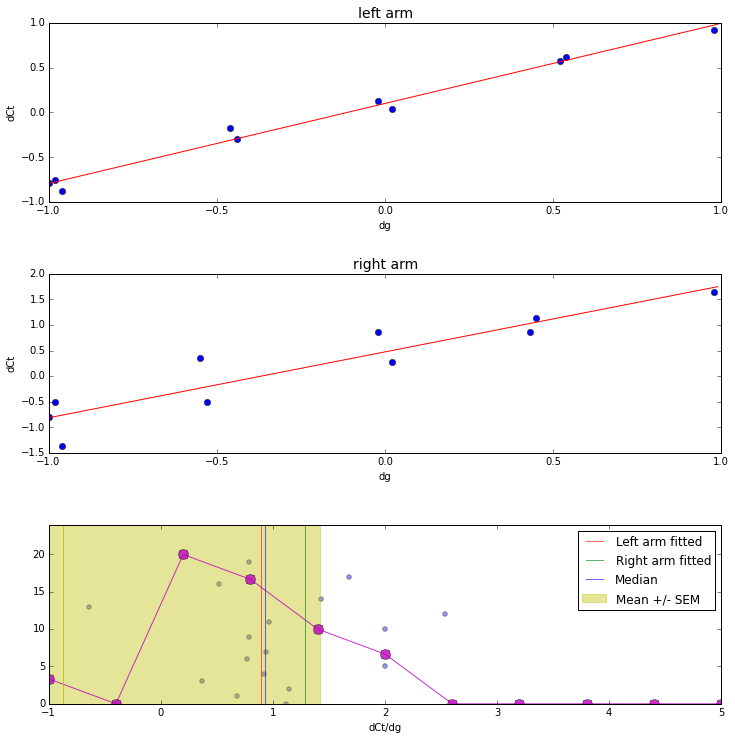

left arm fitted C/tau = 0.893411; right arm fitted C/tau = 1.286817
Median dCt/dg = 0.927721
mean and std and sem = -0.874697, 10.245873, 2.291047
**************************************************
trace number: 49 to 56


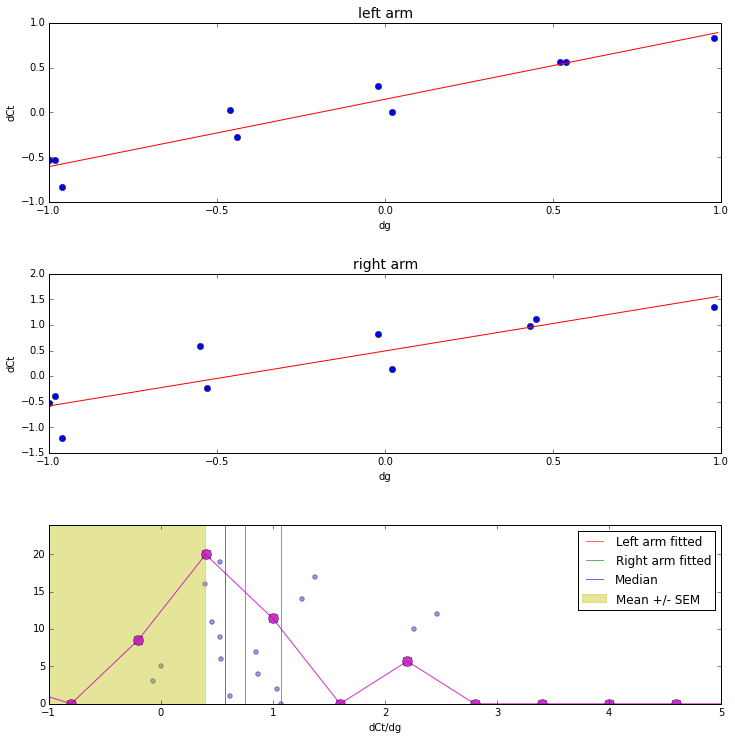

left arm fitted C/tau = 0.752006; right arm fitted C/tau = 1.074103
Median dCt/dg = 0.577226
mean and std and sem = -1.793430, 9.776866, 2.186174
**************************************************
trace number: 57 to 64


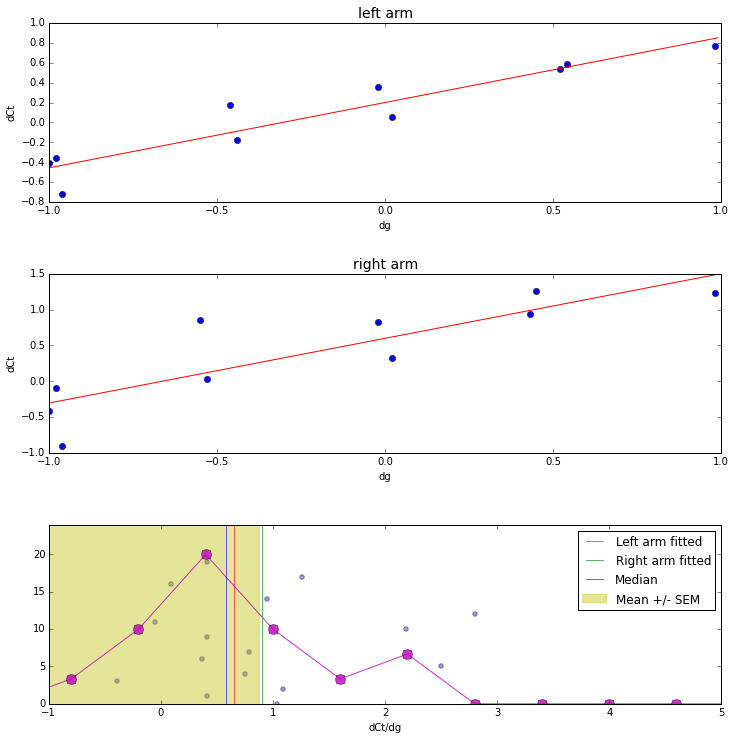

left arm fitted C/tau = 0.656607; right arm fitted C/tau = 0.903437
Median dCt/dg = 0.580000
mean and std and sem = -1.497463, 10.592777, 2.368617
**************************************************
finished: 64
----------------------------------------------------------------------------------------------------


In [19]:
g = np.array(g_1007)
'''
group_1007  = collections.OrderedDict([
        ('CAA', 8*len(g)),
        ('Glc', 8*len(g)), 
        ('Rich', 7*len(g)), 
        ('TSB', 6*len(g))
    ])
'''
'''
group_test = collections.OrderedDict([
        ('6aa', 8*len(g)), 
        ('GenDup', 4*len(g))
    ])

group_all = collections.OrderedDict([
        ('6aa', 7*g.shape[0]),
        ('Gly', 8*g.shape[0]),
        ('Rich', 8*g.shape[0]),
        ('Normal', 8*g.shape[0]),
        ('12aa-frozen', 8*g_12aa.shape[0]),
        ('12aa-fresh', 8*g_12aa.shape[0])
    ]) 
'''
group_1013 = collections.OrderedDict([
        ('Sorbitol', 8*len(g))
        ])
group = group_1013
set_g12 = Set(['12aa-frozen', '12aa-fresh'])
trace_counter = 0
set_num = 0
bad = []
ctau_M = []
ctau_L = []
ctau_R = []
##bad_primer_list = [0.54, -0.45]
##keep_g = [0, 1, 0.02, 0.98, -0.02, -0.98, 0.45, -0.54]
##bad_primer_list = [gx for gx in g if gx not in keep_g]
bad_primer_list = []
for sample, trace_num in group.items():
    print('processing sample %s' %(sample))
    if sample in set_g12:
        set_num = len(g_12aa)
        for i in np.arange(trace_num/g_12aa.shape[0]):
            print('trace number: %d to %d' %(trace_counter + 1, trace_counter + set_num))
            ##fit_range = np.arange(trace_counter, trace_counter + set_num - 1)
            _, _, _, _, tempBad, tempM, tempL, tempR = left_right_pairwise(ct[trace_counter:trace_counter + set_num], g_12aa, eff[trace_counter:trace_counter + set_num], bad_primer_list)
            bad = np.append(bad, tempBad)
            ctau_M = np.append(ctau_M, tempM)
            ctau_L = np.append(ctau_L, tempL)
            ctau_R = np.append(ctau_R, tempR)
            trace_counter = trace_counter + set_num
    else:
        set_num = len(g)
        for i in np.arange(trace_num/g.shape[0]):
            print('trace number: %d to %d' %(trace_counter + 1, trace_counter + set_num))
            ##fit_range = np.arange(trace_counter, trace_counter + set_num - 1)
            _, _, _, _, tempBad, tempM, tempL, tempR = left_right_pairwise(ct[trace_counter:trace_counter + set_num], g, eff[trace_counter:trace_counter + set_num], bad_primer_list)
            bad = np.append(bad, tempBad)
            ctau_M = np.append(ctau_M, tempM)
            ctau_L = np.append(ctau_L, tempL)
            ctau_R = np.append(ctau_R, tempR)
            trace_counter = trace_counter + set_num      
    ##trace_counter = trace_counter + trace_num
    print('finished: %d' % trace_counter)
    print('-'*100)

## C estimation and plotting

In [74]:
len(ctau_M)

47

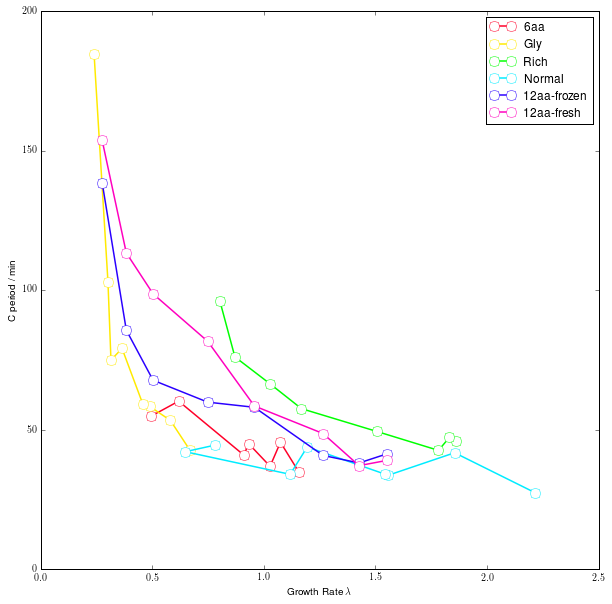

In [79]:
C_M = ctau_M * np.concatenate((tau, tau[-8:])) * np.log2(np.median(eff))
C_L = ctau_L * np.concatenate((tau, tau[-8:])) * np.log2(np.median(eff))
C_R = ctau_R * np.concatenate((tau, tau[-8:])) * np.log2(np.median(eff))

growthRate = 60*np.log(2) / np.concatenate((tau, tau[-8:]))
plt.figure(figsize=(10,10))
counter = 0
plotC = C_M
color_idx = np.linspace(0, 1, len(group))
grp_size = 0

for i, sample, trace_num in zip(color_idx, zip(*group.items())[0], zip(*group.items())[1]) :
    if sample not in set_g12:
        grp_size = trace_num / len(g)
    else:
        grp_size = trace_num / len(g_12aa)
    plt.plot(growthRate[counter : counter+grp_size],  plotC[counter : counter + grp_size], '-o', color = plt.cm.gist_rainbow(i), markeredgecolor = plt.cm.gist_rainbow(i), markerfacecolor = 'w', lw = 1.5, markersize = 10)
    counter = counter + grp_size
plt.ylim((0,140))
plt.legend(['6aa', 'Gly', 'Rich', 'Normal', '12aa-frozen', '12aa-fresh'])
plt.rc('text', usetex=True)
plt.fontsize = 14
plt.xlabel(r'Growth Rate \lambda')
plt.ylabel(r'C period / min')
plt.ylim((0, 200))
plt.show() 


np.savetxt(file_header + '_filter_median.csv', C_M, delimiter = ',')
np.savetxt(file_header + 'filter_left.csv', C_L, delimiter = ',')
np.savetxt(file_header + 'filter_right.csv', C_R, delimiter = ',')

---
#### Plotly import

In [461]:
import plotly.plotly as py
py.sign_in('arfartom', 'sbo2dvdzat')
import plotly.tools as tls

----
Function for calculating amplification efficiency

In [12]:
def fit_for_eff(c_low, c_up, fl, trace_no,  show_plot):
    ## fitting log-transformed data
    ydata = np.log(fl[c_low:c_up+1])
    fitFunc = np.polyfit(fit_range, ydata, 1, full=False, w=None, cov=False)
    yhat = np.polyval(fitFunc, fit_range)

    ## calculating R^2
    ss_tot = np.sum((ydata - np.mean(ydata))**2)  
    ss_res = np.sum((ydata-yhat)**2)
    r_squared = 1 - ss_res/ss_tot

    ## plotting
    if show_plot:
        plt.figure()
        plt.plot(fit_range, yhat, '-', fit_range, ydata, 'o')
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        plt.xlabel('cycles')
        plt.ylabel('log(Fl)')
        plt.title('Linear fitting No.%d, cycles %d to %d' %(trace_no+1, c_low, c_up))
        plt.text(0.1*(xmax-xmin)+xmin, 0.85*(ymax-ymin)+ymin, r'$R^2$ = %f' % (r_squared), fontsize = 14)
        plt.text(0.1*(xmax-xmin)+xmin, 0.75*(ymax-ymin)+ymin, r'Efficiency = %f' %(np.exp(fitFunc[0])), fontsize = 14)
        plt.show()
    return (np.exp(fitFunc[0]), r_squared)

**Function of calculating pairwise ratios**

In [13]:
def pairwise_ct(ct_values, g_coord):
    delta_ct = np.zeros(ct_values.shape[0]*(ct_values.shape[0]-1)/2)
    delta_g = np.zeros(ct_values.shape[0]*(ct_values.shape[0]-1)/2)
    count = 0
    bad = np.zeros(ct_values.shape[0])
    ##print('range: 0 to %d' % (ct_values.shape[0]))
    if False:
        print(ct_values)
        print(g_coord)
    for i in np.arange(ct_values.shape[0]-1):
        for j in np.arange(i+1, ct_values.shape[0]):
            delta_ct[count] = ct_values[i] - ct_values[j]
            delta_g[count] = g_coord[i] - g_coord[j]
            if (delta_ct[count]/delta_g[count] < 0 or delta_ct[count]/delta_g[count] > 5):
            ##if (delta_ct[count]/delta_g[count] < 0):
                bad[i] = bad[i] + 1
                bad[j] = bad[j] + 1
            ##print ('processing %d divided by %d: delta_ct = %f, delta_g = %f' % (i, j, delta_ct[count], delta_g[count]))
            count = count + 1
    ## plotting delta_ct against delta_g            
    if False:
        plt.figure()
        plt.plot(delta_g, delta_ct, 'o')
        plt.show()

    return (delta_ct, delta_g, bad) 

In [15]:
def left_right_pairwise(ct_values, g_coord, amp_eff, primer_filters):
    if primer_filters:    
        g_coord, ct_values = np.array(filter_function(primer_filters, g_coord, ct_values))
    bad = np.zeros(len(g_coord))
    g_right = np.concatenate((g_coord[g_coord[:-2] > 0], g_coord[-2:]), axis = 0)
    ct_right = np.concatenate((ct_values[g_coord[:-2] > 0], ct_values[-2:]), axis = 0)
    eff_right = np.concatenate((amp_eff[g_coord[:-2] > 0], amp_eff[-2:]), axis = 0)
    #g_right = g_coord[g_coord[:] > 0]
    #ct_right = ct_values[g_coord[:] > 0]
    #eff_right = amp_eff[g_coord[:] > 0]
    dCtR, dgR, badR = pairwise_ct(ct_right, g_right)
    #print(g_right, ct_right, eff_right)
    g_left = np.abs(np.concatenate((g_coord[g_coord[:-2] < 0],  [0, 1]), axis = 0)) 
    ct_left = np.concatenate((ct_values[g_coord[:-2] < 0],  ct_values[-2:]), axis = 0)
    eff_left = np.concatenate((amp_eff[g_coord[:-2] < 0], amp_eff[-2:]), axis = 0)
    #g_left = np.abs(g_coord[g_coord[:] < 0]) 
    #ct_left = ct_values[g_coord[:] < 0]
    #eff_left = amp_eff[g_coord[:] < 0]
    dCtL, dgL, badL = pairwise_ct(ct_left, g_left)
    dCtdR = np.concatenate((dCtL/dgL, dCtR/dgR), axis = 0)
    
    ## plotting and chekcing outputs
    if True:
        fig,_ = plt.subplots(figsize=(10,10))
        fig.tight_layout()
        plt.subplots_adjust(hspace=0.4)
        plt.subplot(3,1,1)
        plt.plot(dgL, dCtL, 'bo')
        plt.title('left arm', fontsize = 14)
        plt.ylabel('dCt')
        plt.xlabel('dg')
        
        plt.subplot(3,1,2)
        plt.plot(dgR, dCtR, 'bo')
        plt.title('right arm', fontsize = 14)
        plt.ylabel('dCt')
        plt.xlabel('dg')
        
        plt.subplot(3,1,3)
        plt.scatter(np.concatenate((dCtL/dgL, dCtR/dgR), axis = 0), np.arange(dCtR.shape[0]+dCtL.shape[0]), alpha = 0.4)
        plt.xlabel('dCt/dg')
        ## histogram of dct/dg
        
        hist_bin, bin_edges = np.histogram(dCtdR, bins = np.arange(np.min(dCtdR), np.max(dCtdR), 0.6) , density=1)
        plt.plot(bin_edges[:-1], (len(dCtR)+len(dCtL))*hist_bin/np.max(hist_bin), 'm-o', alpha = 0.8, ms = 10)
        ## fitting dCt to dg
        plt.subplot(3,1,1)
        fitmdl_L = np.polyfit(dgL, dCtL, 1)
        xmin, xmax = plt.xlim()
        yhat_L = np.polyval(fitmdl_L, np.arange(xmin, xmax, 0.01))
        plt.plot(np.arange(xmin, xmax, 0.01), yhat_L, 'r-')
        
        plt.subplot(3,1,2)
        fitmdl_R = np.polyfit(dgR, dCtR, 1)
        xmin, xmax = plt.xlim()
        yhat_R = np.polyval(fitmdl_R, np.arange(xmin, xmax, 0.01))
        plt.plot(np.arange(xmin, xmax, 0.01), yhat_R, 'r-')
        
        plt.subplot(3,1,3)
        ax_L = plt.axvline(x=fitmdl_L[0], color='r', alpha = 0.6)
        ax_R = plt.axvline(x=fitmdl_R[0], color = 'g', alpha = 0.6)
        ax_M = plt.axvline(x=np.median(np.concatenate((dCtL/dgL, dCtR/dgR), axis = 0)), color = 'b', alpha = 0.6)
        ax_mean = plt.axvspan(np.mean(dCtdR)-np.std(dCtdR)/np.sqrt(len(dCtdR)), np.mean(dCtdR)+np.std(dCtdR)/np.sqrt(len(dCtdR)), color = 'y', alpha =0.4)
        plt.axvline(np.mean(dCtdR), color='y', alpha = 0.8)
        plt.legend([ax_L, ax_R, ax_M, ax_mean], ['Left arm fitted', 'Right arm fitted', 'Median', 'Mean +/- SEM'], loc = 'upper right')
        plt.xlim((-1, 5))
        plt.ylim((0, 1.2*len(dCtdR)))
        plt.show(fig)

        print('left arm fitted C/tau = %f; right arm fitted C/tau = %f' %(fitmdl_L[0], fitmdl_R[0]))
        print('Median dCt/dg = %f' %(np.median(dCtdR))) 
        print('mean and std and sem = %f, %f, %f' %(np.mean(dCtdR), np.std(dCtdR), np.std(dCtdR)/np.sqrt(len(dCtdR)) ))
        print('*'*50)
    ## output bad-fitting primers
    if False:
        print('Median dCt/dg = %f' %(np.median(np.concatenate((dCtL/dgL, dCtR/dgR), axis = 0)))) 
        print('Left arm bad primers')
        print(badL)
        print('Right arm bad primes')
        print(badR)
    bad = np.concatenate((badR[:-2], badL[:-2], badR[-2:]+badL[-2:]), axis = 0)
    
    return (dCtL, dgL, dCtR, dgR, bad, np.median(dCtdR[dCtdR>0]), fitmdl_L[0], fitmdl_R[0])

In [14]:
def filter_function(filter_id, id_list, item_list):
    new_id_list_size = len(id_list) - len(filter_id)
    new_item_list = np.zeros((len(item_list) / len(id_list))*new_id_list_size)
    filter_id = set(filter_id)
    trash = np.zeros(new_id_list_size)
    for i in range( len(item_list) / len(id_list) ):
        temp = zip(id_list, item_list[i*len(id_list) : (i+1)*len(id_list)])
        _,new_item_list[i*new_id_list_size:(i+1)*new_id_list_size] = zip(*[new_item for new_item in temp if new_item[0] not in filter_id])
    new_id_list = [ids for ids in id_list if ids not in filter_id]   
    
    return (new_id_list, new_item_list)

In [110]:
def dm_pairwise_ct(ct_values, g_coord):
    print(ct_values)
    print(g_coord)

**Plotting bad primer frequency!**

In [611]:
bad_formatted = np.array(bad).reshape((-1, len(g)-len(bad_primer_list)))
plt.figure(figsize = (20,10))
##bar_ind = np.arange(g_12aa.shape[0])
bar_ind = np.arange(len(g)-len(bad_primer_list))
bar_width = 0.65
##plt.bar(bar_ind, np.concatenate((np.sum(bad_g12[:,:-2], axis = 0)/(10*8*2), np.sum(bad_g12aa[:,-2:], axis = 0)/(10*8*2*2))), bar_width, color='b')
plt.bar(bar_ind, np.concatenate((np.sum(bad_formatted[:,:-2], axis = 0)/(13*2), np.sum(bad_formatted[:,-2:], axis = 0)/(13*2*2))), bar_width, color='b')
plt.xticks(bar_ind + bar_width/2., ([str(x) for x in g if x not in bad_primer_list]), rotation=45)
plt.ylim((0,1))
plt.ylabel('Frequency')
plt.xlabel('Primer coordinates g')
plt.title('bad primer frequency')
plt.xlim((0, len(bar_ind)))
plt.show()

ValueError: total size of new array must be unchanged

[ 1.5147864   1.55408836  1.59339032  1.63269228  1.67199424  1.71129619
  1.75059815  1.78990011  1.82920207  1.86850403]


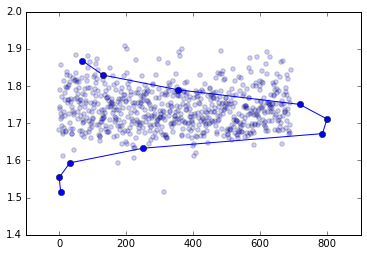

In [307]:
plt.figure()
hist_bin, bin_edges = np.histogram(eff, bins=10, normed=1)
print(bin_edges[:-1])
##plt.barh(bin_edges[:-1] , 800*hist_bin/np.max(hist_bin) , 0.02, facecolor='green', alpha = 0.5)
plt.scatter(np.arange(len(eff)), eff, alpha = 0.2)
plt.plot(800*hist_bin/np.max(hist_bin), bin_edges[:-1] , '-o')
plt.show()
      

In [377]:
unzip = zip(*group.items())[0]
col1 = unzip[0]
col2 = unzip[1]
col3 = (1,2,3,4,5,6)
final = zip(zip(*group.items())[0], zip(*group.items())[1], col3)
print(final)

[('6aa', 84, 1), ('Gly', 96, 2), ('Rich', 96, 3), ('Normal', 96, 4), ('12aa-frozen', 160, 5), ('12aa-fresh', 160, 6)]


In [698]:
np.array([1.155413, 10.242867, 2.290375]) * 22.4183* np.log2(np.median(eff))

array([  21.13148985,  187.33304892,   41.88894886])

In [618]:
g_all

array([ 0.09,  0.18,  0.27,  0.36,  0.45,  0.54,  0.63,  0.7 ,  0.81,
        0.9 , -0.9 , -0.81, -0.72, -0.63, -0.54, -0.45, -0.36, -0.27,
       -0.18, -0.09, -0.02,  0.02, -0.98,  0.98,  0.  ,  1.  ])

In [731]:
np.savetxt('/Users/dongyang/Desktop/eff_est.csv', np.exp(np.log(10)/(ct[26:]-ct[:26])), delimiter = ',')
np.savetxt('/Users/dongyang/Desktop/eff_mean.csv',np.reshape(eff, (2, 26)), delimiter=',')

In [625]:
(eff[:26]+eff[26:])/2

array([ 1.74611446,  1.7911463 ,  1.73786713,  1.75767332,  1.78162127,
        1.77617638,  1.80734753,  1.76768409,  1.70704455,  1.6694868 ,
        1.94859734,  1.61850028,  1.79909519,  1.72799014,  1.71766325,
        1.73766384,  1.7573619 ,  1.81945196,  1.78402194,  1.76270172,
        1.80422932,  2.01559649,  1.73069814,  1.62930738,  1.71154861,
        1.79110734])

In [729]:
eff

array([ 1.70108028,  1.79243157,  1.7139878 ,  1.72356007,  1.74317669,
        1.69743372,  1.78974929,  1.72495695,  1.6592375 ,  1.71580939,
        1.73716364,  1.30702221,  1.73848995,  1.80145123,  1.76135831,
        1.72422609,  1.73601259,  1.77224845,  1.79090275,  1.83393583,
        1.75921941,  2.06425464,  1.75178945,  1.67588164,  1.71449754,
        1.81461304,  1.79114864,  1.78986103,  1.76174646,  1.79178657,
        1.82006584,  1.85491904,  1.82494576,  1.81041122,  1.7548516 ,
        1.62316421,  2.16003104,  1.92997835,  1.85970044,  1.65452905,
        1.67396819,  1.75110158,  1.77871121,  1.86665547,  1.77714113,
        1.69146762,  1.84923923,  1.96693835,  1.70960684,  1.58273312,
        1.70859969,  1.76760163])

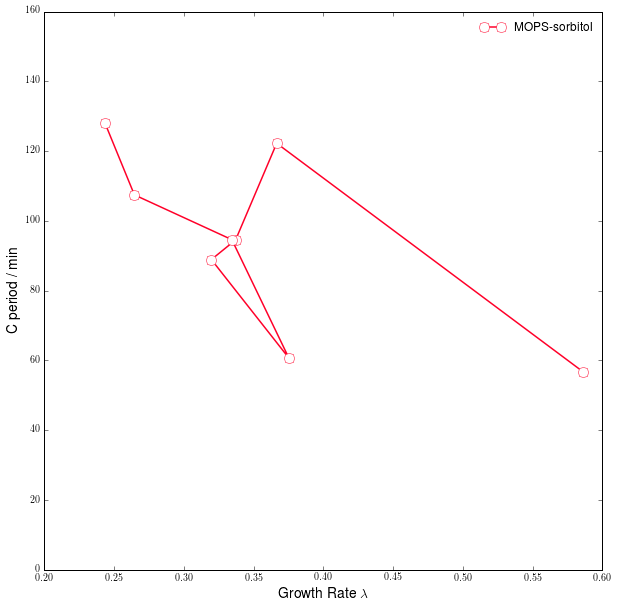

In [29]:
file_header = '20151013_MOPS_sorbitol_'

C_M = ctau_M * tau * np.log2(np.nanmedian(eff))
C_L = ctau_L * tau * np.log2(np.nanmedian(eff))
C_R = ctau_R * tau * np.log2(np.nanmedian(eff))
C_M
growthRate = 60*np.log(2) / tau

plt.figure(figsize=(10,10))
counter = 0
plotC = C_M
color_idx = np.linspace(0, 1, len(group))
grp_size = 0

for i, sample, trace_num in zip(color_idx, zip(*group.items())[0], zip(*group.items())[1]) :
    if sample not in set_g12:
        grp_size = trace_num / len(g)
    else:
        grp_size = trace_num / len(g_12aa)
    plt.plot(growthRate[counter : counter+grp_size],  plotC[counter : counter + grp_size], '-o', color = plt.cm.gist_rainbow(i), markeredgecolor = plt.cm.gist_rainbow(i), markerfacecolor = 'w', lw = 1.5, markersize = 10)
    counter = counter + grp_size
plt.ylim((0,140))
plt.legend(['MOPS-sorbitol'], frameon=0, loc = 'best')
#plt.legend(['CAA', 'Glucose', 'Rich', 'TSB'])
plt.rc('text', usetex=True)
plt.xlabel(r'Growth Rate \lambda', fontsize = 14)
plt.ylabel(r'C period / min', fontsize = 14)
plt.fontsize = 14
plt.ylim((0, 160))
plt.show() 
if True:
    np.savetxt(file_header + 'filter_median_1010.csv', C_M, delimiter = ',')
    np.savetxt(file_header + 'filter_left_1010.csv', C_L, delimiter = ',')
    np.savetxt(file_header + 'filter_right_1010.csv', C_R, delimiter = ',')


--